In [1]:
# add system environment variable
import sys
sys.path.append('/workspace/ControlNet_jh/ControlNet')

import torch
from PIL import Image
from diffusers import StableDiffusionInpaintPipeline
from customs.pipes.control_inpaint_pipe import StableDiffusionControlNetInpaintPipeline
from transformers import CLIPTextModel, CLIPTokenizer
import customs.custom_api as custom_api

from diffusers.schedulers.scheduling_euler_ancestral_discrete import EulerAncestralDiscreteScheduler


controlnet_path = "/data3/model_checkpoints/DIFFUSION_DB/ControlNet/diffusers/control_sd15_openpose"
SD_inpainting_path = '/data3/model_checkpoints/DIFFUSION_DB/Diffusion_models/diffusers/v15/Realistic_Vision_V1.3.inpainting'
embed_path = '/data3/model_checkpoints/DIFFUSION_DB/embeddings/v15'
embed_list = ['bad-hands','real-korean-style']

# load tokenizer
tokenizer = CLIPTokenizer.from_pretrained(
    controlnet_path,
    subfolder="tokenizer",
)
text_encoder = CLIPTextModel.from_pretrained(
    controlnet_path, 
    subfolder="text_encoder", 
    torch_dtype=torch.float16
)

# add tokens
custom_api.add_token(embed_path=embed_path,tokens=embed_list,tokenizer=tokenizer,text_encoder=text_encoder)

# load scheduler
scheduler = EulerAncestralDiscreteScheduler()

# load model & merge
pipe_control = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    controlnet_path,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    scheduler = scheduler,
    torch_dtype=torch.float16).to('cuda')
pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(SD_inpainting_path,torch_dtype=torch.float16).to('cuda')

pipe_control.unet = pipe_inpaint.unet
pipe_control.unet.in_channels = 4

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


bad-hands added to CLIP tokenizer
real-korean-style added to CLIP tokenizer


/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


cuda
cuda


100%|██████████| 25/25 [00:02<00:00,  9.43it/s]


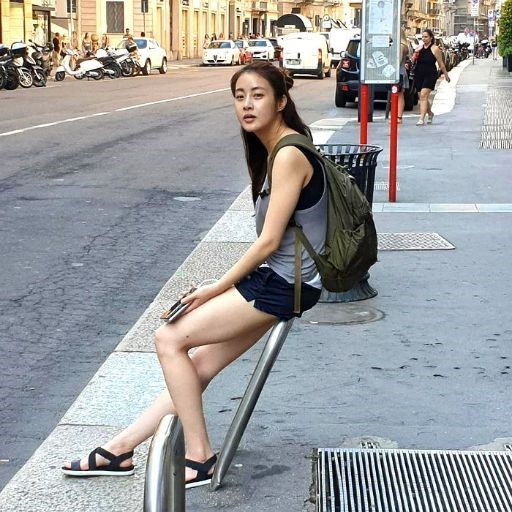

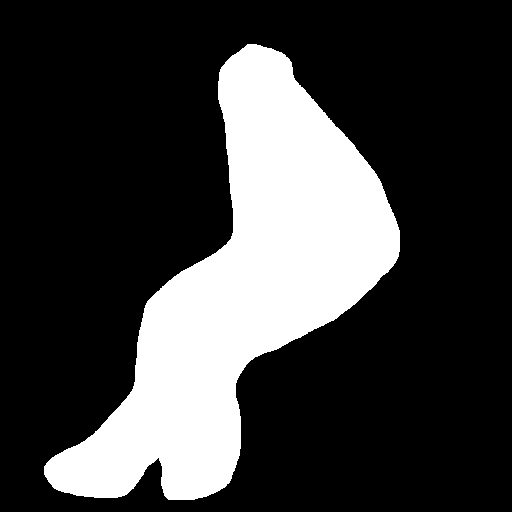

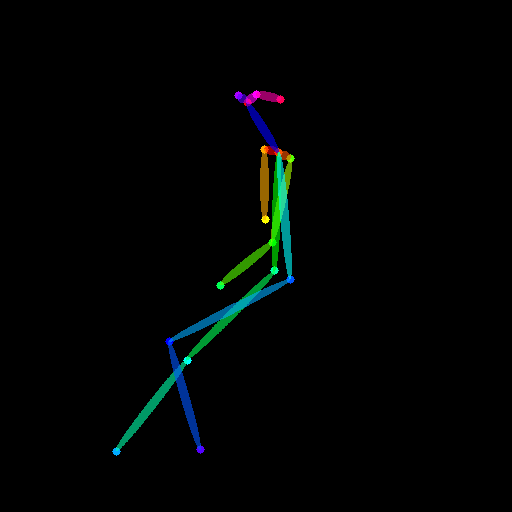

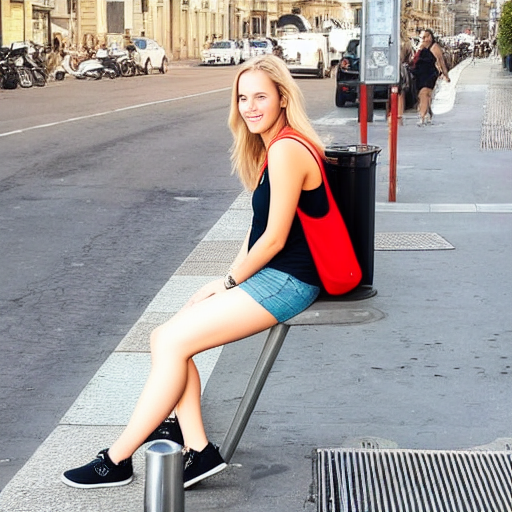

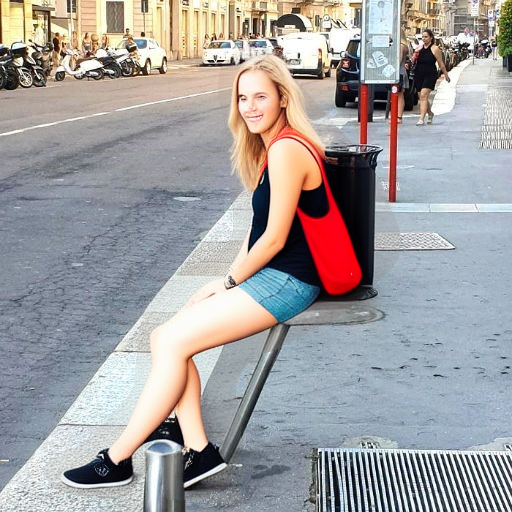

In [12]:
from ControlNet.annotator.openpose import OpenposeDetector
from ControlNet.annotator.util import HWC3
import numpy as np

# load image & mask
image = Image.open("/workspace/ControlNet_jh/test_images/image1.jpg")
mask = Image.open("/workspace/ControlNet_jh/test_images/image1_mask.jpg")   # 지우는 부분: [255,255,255] 아닌부분: [0,0,0]

# image preprocess
image = custom_api.resize_padding(image)
image = np.asanyarray(image)
image = HWC3(image)
mask = custom_api.resize_padding(mask)

# get condition
apply_openpose = OpenposeDetector()
detected_map, _ = apply_openpose(image)

# inputs to PIL Image
detected_map = Image.fromarray(detected_map)
image = Image.fromarray(image)

# seed
custom_api.seed_everything(seed=689174160)

# run inference
out_image = pipe_control(
    prompt="RAW photo, a portrait photo of 25 y.o swedish woman in casual clothes, night, city street, (high detailed skin:1.2), 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3", 
    negative_prompt='(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime:1.4), text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck',
    controlnet_hint=detected_map, 
    image=image,
    mask_image=mask,
    num_inference_steps=25,
    guidance_scale=7).images[0]


image.show()
mask.show()
detected_map.show()
out_image.show()

# merge
image = np.array(image)
out_image = np.array(out_image)
mask = np.array(mask)
out_image[np.where(np.array(mask)==0)] = image[np.where(np.array(mask)==0)]
Image.fromarray(out_image)